<a href="https://colab.research.google.com/github/zainali60/CNN-MNIST/blob/main/Flower_reg_tensorflow_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob
import tensorflow as tf
from os import listdir
from os.path import join
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data = pathlib.Path(data)

228827136/228813984 [==============================] - 2s 0us/step


In [5]:
image_count = len(list(data.glob('*/*.jpg')))
print(image_count)

3670


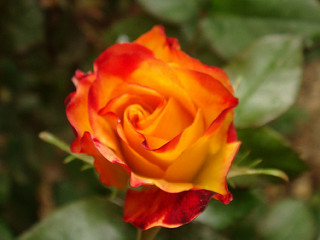

In [6]:
roses = list(data.glob('roses/*'))
PIL.Image.open(str(roses[1]))

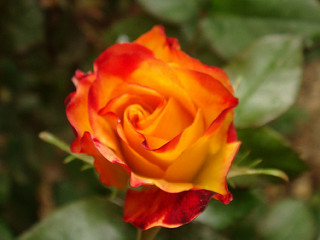

In [7]:
PIL.Image.open(str(roses[1]))


In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data,validation_split=0.2,subset="training",
                                                               seed=123,image_size=(img_height, img_width),
                                                                batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


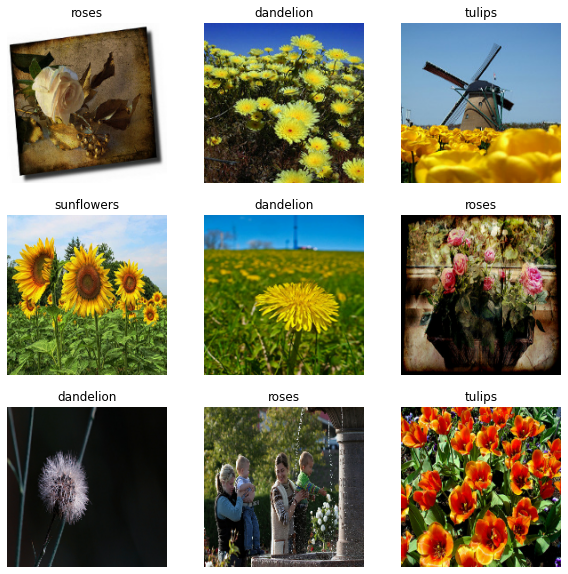

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [14]:
print(labels_batch)

tf.Tensor([3 3 4 4 1 3 4 3 4 4 1 3 0 0 2 4 1 3 1 1 1 3 1 2 1 3 4 1 4 4 4 3], shape=(32,), dtype=int32)


In [15]:
image_batch[0]

<tf.Tensor: shape=(180, 180, 3), dtype=float32, numpy=
array([[[ 88.388885 , 124.388885 , 200.38889  ],
        [ 88.92778  , 124.92778  , 200.92778  ],
        [ 88.83426  , 125.369446 , 199.21297  ],
        ...,
        [214.58     ,  86.53922  ,   0.2936081],
        [233.40553  , 102.67497  ,   5.1722207],
        [228.70369  ,  97.68517  ,   2.5083113]],

       [[ 90.27778  , 126.27778  , 202.27779  ],
        [ 90.86666  , 127.15     , 203.00833  ],
        [ 95.05278  , 133.0361   , 206.15555  ],
        ...,
        [161.44466  ,  69.41103  ,   9.163834 ],
        [172.70831  ,  64.72499  ,   1.3749431],
        [153.86942  ,  63.70556  ,   4.155579 ]],

       [[ 93.02778  , 131.02779  , 206.02779  ],
        [ 92.75     , 130.81944  , 205.81944  ],
        [ 98.35185  , 137.16203  , 209.87962  ],
        ...,
        [118.51407  ,  59.675957 ,   8.26374  ],
        [167.69493  , 102.569954 ,  42.9172   ],
        [226.2223   , 190.91681  , 168.24559  ]],

       ...,

     

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [50]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [17]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [19]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [22]:
epochs=10
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
92/92 [==============================] - 94s 1s/step - loss: 1.3539 - accuracy: 0.4114 - val_loss: 1.1004 - val_accuracy: 0.5545
Epoch 2/10
92/92 [==============================] - 92s 997ms/step - loss: 0.9963 - accuracy: 0.6093 - val_loss: 0.9650 - val_accuracy: 0.6199
Epoch 3/10
92/92 [==============================] - 91s 991ms/step - loss: 0.8336 - accuracy: 0.6781 - val_loss: 0.8573 - val_accuracy: 0.6744
Epoch 4/10
92/92 [==============================] - 91s 994ms/step - loss: 0.6220 - accuracy: 0.7732 - val_loss: 0.8887 - val_accuracy: 0.6839
Epoch 5/10
92/92 [==============================] - 92s 996ms/step - loss: 0.4121 - accuracy: 0.8478 - val_loss: 0.9936 - val_accuracy: 0.6689
Epoch 6/10
92/92 [==============================] - 91s 992ms/step - loss: 0.2302 - accuracy: 0.9247 - val_loss: 1.1400 - val_accuracy: 0.6649
Epoch 7/10
92/92 [==============================] - 91s 993ms/step - loss: 0.1381 - accuracy: 0.9571 - val_loss: 1.3117 - val_accuracy: 0.6703
Ep

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_accuracy = history_dict['accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)
#epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_accuracy, 'b', label='accuracy')
plt.title('accuracy  and loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Training and Validation Accuracy')

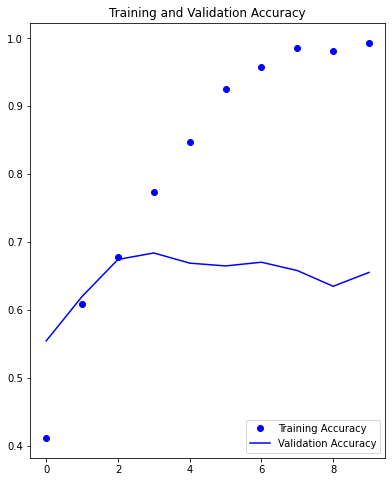

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,'bo', label='Training Accuracy')
plt.plot(epochs_range, val_acc,'b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



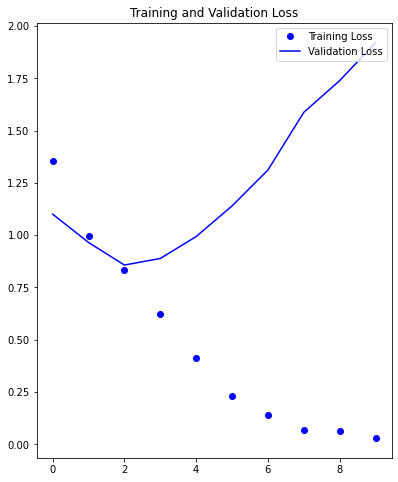

In [31]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,'bo', label='Training Loss')
plt.plot(epochs_range, val_loss,'b', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

131072/117948 [=================================] - 0s 0us/step
This image most likely belongs to sunflowers with a 60.88 percent confidence.


In [33]:
model.save('Flower reg tensorflow CNN.h5')


In [34]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [42]:
model = load_model('Flower reg tensorflow CNN.h5')


-9.581726


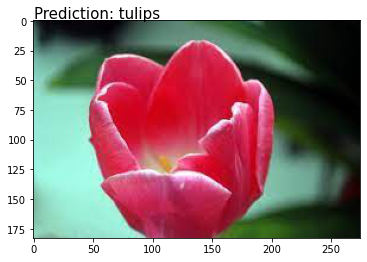

-17.53306


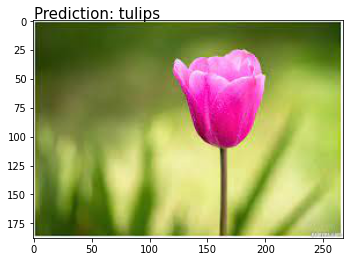

0.8339382
0.8339382


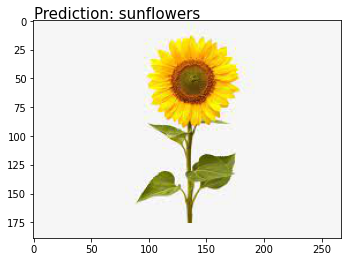

0.7591087
0.7591087


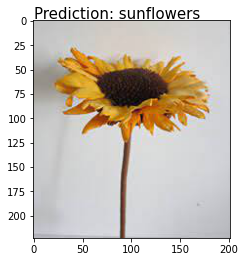

-1.522331


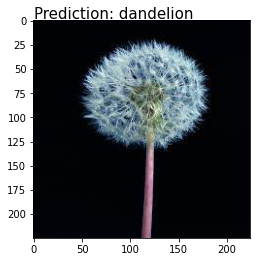

-8.254735


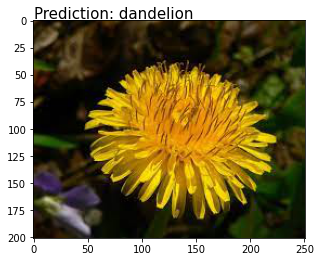

In [49]:
for i in range(1, 7):
  test_image = image.load_img(str(i) + '.jpg', target_size=(180, 180))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis=0)
  result = model.predict(test_image)
  print(result[0][0])
  if result[0][0] >= 0.5:
    print(result[0][0])
    prediction = 'sunflowers'
  elif  result[0][0] <= -9.0:
    prediction = 'tulips'
  else:
    prediction = 'dandelion'
    
  img = mpimg.imread(str(i) +'.jpg')
  imgplot = plt.imshow(img)
  plt.text(x=0, y=-2, s='Prediction: ' + prediction, fontsize=15)
  plt.show()